In [1]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return the number of GPUs
print(torch.cuda.get_device_name(0))  # Should show the GPU model

True
1
NVIDIA RTX 5000 Ada Generation


In [2]:
from scipy.stats import chi2 , probplot
from sklearn.covariance import MinCovDet
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import os
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# Load the CSV files
output_base = "../LMForge_RUN04/Generated_Results/microsoft_phi-4"
if os.path.exists(f"{output_base}/scores_microsoft_phi-4.csv"):
    print(f"File {output_base}/scores.csv exists.")
    #print("Exists")
else:
    print(f"File {output_base}/scores.csv exists.")
    #print("Doesn't Exist")
# Read the CSV file
scores_df = pd.read_csv(f"{output_base}/scores_microsoft_phi-4.csv")
# drop duplicates
scores_df = scores_df.drop_duplicates(subset=["chunk_size", "max_tokens"], keep="first").drop(columns=["elapsed_time","questions_num"])

dv_columns = [
    "rouge1", "rouge2", "rougeL", "rougeLsum",
    "bert_score_P", "bert_score_R", "bert_score_F1",
    "sts_score"
]

File ../LMForge_RUN04/Generated_Results/microsoft_phi-4/scores.csv exists.


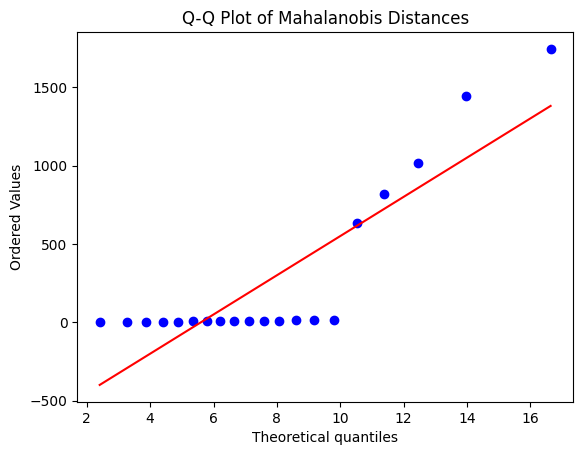

Henze-Zirkler Test:
 HZResults(hz=np.float64(1.7542283000632457), pval=np.float64(1.83015839319215e-71), normal=False)


In [3]:
# Select only the dependent variables (DVs)
X = scores_df[dv_columns].dropna()

# Compute robust Mahalanobis distances
robust_cov = MinCovDet().fit(X)
mahalanobis_distances = robust_cov.mahalanobis(X)

# Chi-squared Q-Q plot
probplot(mahalanobis_distances, dist="chi2", sparams=(len(dv_columns),), plot=plt)
plt.title("Q-Q Plot of Mahalanobis Distances")
plt.show()

# Formal multivariate normality test (Henze-Zirkler's)
normality_test = pg.multivariate_normality(scores_df[dv_columns], alpha=0.05)
print("Henze-Zirkler Test:\n", normality_test)


In [4]:
# Calculate the threshold for outliers
threshold = chi2.ppf(0.99, df=len(dv_columns))
outliers = mahalanobis_distances > threshold
# Print the number of outliers
print(f"Outlier count: {np.sum(outliers)}")
# identifying the outliers
outlier_indices = np.where(outliers)[0]
outlier_rows = scores_df.iloc[outlier_indices]
print("Outlier rows:")
print(outlier_rows)


Outlier count: 5
Outlier rows:
    chunk_size  max_tokens    rouge1    rouge2    rougeL  rougeLsum  \
0          128         128  0.179622  0.144523  0.162473   0.172467   
5          256         128  0.057730  0.033792  0.048095   0.054987   
10         512         128  0.035648  0.027429  0.034468   0.034999   
11         512         256  0.173117  0.111239  0.129730   0.164855   
15        1024         128  0.015479  0.013282  0.015551   0.015482   

    bert_score_P  bert_score_R  bert_score_F1  sts_score substring_date  
0       0.756303      0.388743       0.509486   0.483891  LMForge_RUN04  
5       0.658964      0.330342       0.435280   0.432641  LMForge_RUN04  
10      0.675765      0.299440       0.411327   0.435915  LMForge_RUN04  
11      0.715650      0.430837       0.533577   0.568835  LMForge_RUN04  
15      0.714854      0.326457       0.447357   0.427830  LMForge_RUN04  


In [5]:
## homogeneity of covariance matrices 
# Box's M test
scores_df["group"] = scores_df["chunk_size"].astype(str)

# Then re-clean and re-test
df_clean = scores_df.dropna(subset=dv_columns + ["group"])
box_m = pg.box_m(data=df_clean, dvs=dv_columns, group='group')
print("Box’s M Test:\n", box_m)

Box’s M Test:
      Chi2     df  pval  equal_cov
box   inf  108.0   0.0      False


d:\Anaconda\envs\openfl\lib\site-packages\pingouin\multivariate.py:386: RuntimeWarning: divide by zero encountered in log
  u = -2 * (1 - c) * np.log(M)


In [7]:
threshold = chi2.ppf(0.999, df=X.shape[1])  # 99.9% cutoff
outlier_flags = mahalanobis_distances > threshold
num_outliers = np.sum(outlier_flags)

# summary of outlier results
outlier_summary = pd.DataFrame([{
    "Total Observations": len(mahalanobis_distances),
    "Outliers Detected (p < 0.001)": num_outliers,
    "Percentage Outliers": 100 * num_outliers / len(mahalanobis_distances)
}])
print(outlier_summary)

   Total Observations  Outliers Detected (p < 0.001)  Percentage Outliers
0                  20                              5                 25.0


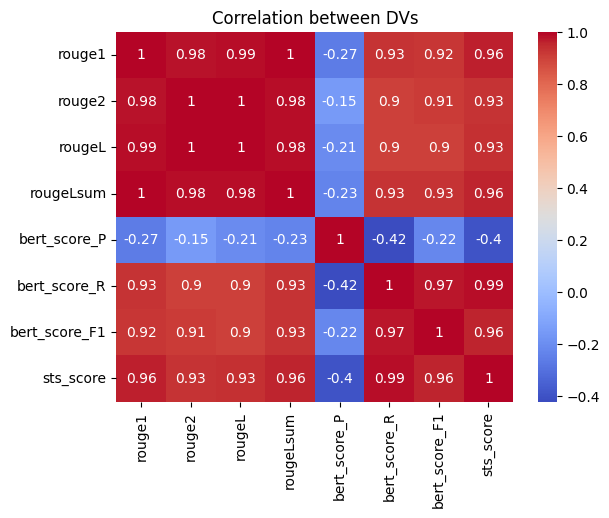

In [8]:
# Check correlation between DVs
sns.heatmap(scores_df[dv_columns].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between DVs")
plt.show()


In [9]:
# Check for multicollinearity

# Add a constant to the model
X_with_const = add_constant(X)
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)

         feature           VIF
0          const  11869.514614
1         rouge1   8434.719781
2         rouge2   3483.984457
3         rougeL   3478.976633
4      rougeLsum   7393.700132
5   bert_score_P     53.924677
6   bert_score_R   1011.161982
7  bert_score_F1    837.298247
8      sts_score    107.928295


In [10]:
# Define DVs
dv_columns = [
    "rouge1", "rouge2", "rougeL", "rougeLsum",
    "bert_score_P", "bert_score_R", "bert_score_F1", "sts_score"
]

# Create group variable
scores_df["group"] = scores_df["chunk_size"].astype(str)

# Drop missing
df_simple = scores_df.dropna(subset=dv_columns + ["group"])

# Create MANOVA formula
formula_simple = " + ".join(dv_columns) + " ~ group"

# Fit MANOVA
maov_simple = MANOVA.from_formula(formula_simple, data=df_simple)
print(maov_simple.mv_test())


                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept          Value   Num DF Den DF  F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda    0.0003 8.0000 9.0000 4273.2210 0.0000
         Pillai's trace    0.9997 8.0000 9.0000 4273.2210 0.0000
 Hotelling-Lawley trace 3798.4186 8.0000 9.0000 4273.2210 0.0000
    Roy's greatest root 3798.4186 8.0000 9.0000 4273.2210 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
         group           Value    Num DF  Den DF F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda   0.0005 24.0000 26.7040  14.4034 0.0000
         Pillai's trace   2.2165 24.0000 33.0

In [11]:
# Type III ANOVA

# Fit the model using OLS
def type_3(formula, data):
    """
    Perform Type III ANOVA using the given formula and data.
    """
    model = ols(formula, data=data).fit()
    anova_results = anova_lm(model, typ=3)
    return anova_results

# Perform Type III ANOVA for each dependent variable
results = []
for column in dv_columns:
    formula = f"{column} ~ group"
    anova_results = type_3(formula, df_clean)
    print(f"ANOVA results for {column}:\n", anova_results)
    results.append((column, anova_results))

# results
anova_results_dict = {column: result for column, result in results}



ANOVA results for rouge1:
              sum_sq    df         F    PR(>F)
Intercept  0.120072   1.0  6.672040  0.020019
group      0.138284   3.0  2.561342  0.091247
Residual   0.287941  16.0       NaN       NaN
ANOVA results for rouge2:
              sum_sq    df          F    PR(>F)
Intercept  0.039976   1.0  10.319183  0.005435
group      0.036011   3.0   3.098533  0.056459
Residual   0.061983  16.0        NaN       NaN
ANOVA results for rougeL:
              sum_sq    df         F    PR(>F)
Intercept  0.053662   1.0  9.804244  0.006445
group      0.060551   3.0  3.687634  0.034264
Residual   0.087574  16.0       NaN       NaN
ANOVA results for rougeLsum:
              sum_sq    df         F    PR(>F)
Intercept  0.107827   1.0  7.465510  0.014761
group      0.100068   3.0  2.309438  0.115240
Residual   0.231094  16.0       NaN       NaN
ANOVA results for bert_score_P:
              sum_sq    df            F        PR(>F)
Intercept  2.345821   1.0  2058.089965  2.471337e-18
group     

In [12]:
scores_df["group"] = scores_df["chunk_size"].astype(str)
df_simple = scores_df.dropna(subset=dv_columns + ["group"])

# Create distance matrix and group labels reference: https://scikit.bio/docs/dev/generated/skbio.stats.distance.html
X = df_simple[dv_columns].values
group_labels = df_simple["group"].values
distance_matrix = DistanceMatrix(squareform(pdist(X, metric='euclidean')))

# Run PERMANOVA
results = permanova(distance_matrix, grouping=group_labels, permutations=999)
print("PERMANOVA results for chunk_size groups:")
print(results)



scores_df["group2"] = scores_df[["max_tokens"]].astype(str)
# Create distance matrix and group labels
X2 = scores_df[dv_columns].values
distance_matrix2 = DistanceMatrix(squareform(pdist(X2, metric='euclidean')))
# Run PERMANOVA for the second group
results2 = permanova(distance_matrix2, grouping=scores_df["group2"].values, permutations=999)
print("PERMANOVA results for max_tokens groups:")
print(results2)



PERMANOVA results for chunk_size groups:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      20
number of groups                  4
test statistic             1.958515
p-value                       0.153
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA results for max_tokens groups:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      20
number of groups                  5
test statistic             7.254529
p-value                       0.004
number of permutations          999
Name: PERMANOVA results, dtype: object


MANOVA results on PCA components:
                  Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.8439 2.0000 15.0000  1.3869 0.2801
         Pillai's trace 0.1561 2.0000 15.0000  1.3869 0.2801
 Hotelling-Lawley trace 0.1849 2.0000 15.0000  1.3869 0.2801
    Roy's greatest root 0.1849 2.0000 15.0000  1.3869 0.2801
------------------------------------------------------------
                                                            
------------------------------------------------------------
         group          Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6748 6.0000 30.0000  1.0868 0.3926
         Pillai's trace 0.3511 6.0000 32.0000  1.1355 0.3646
 Hotell

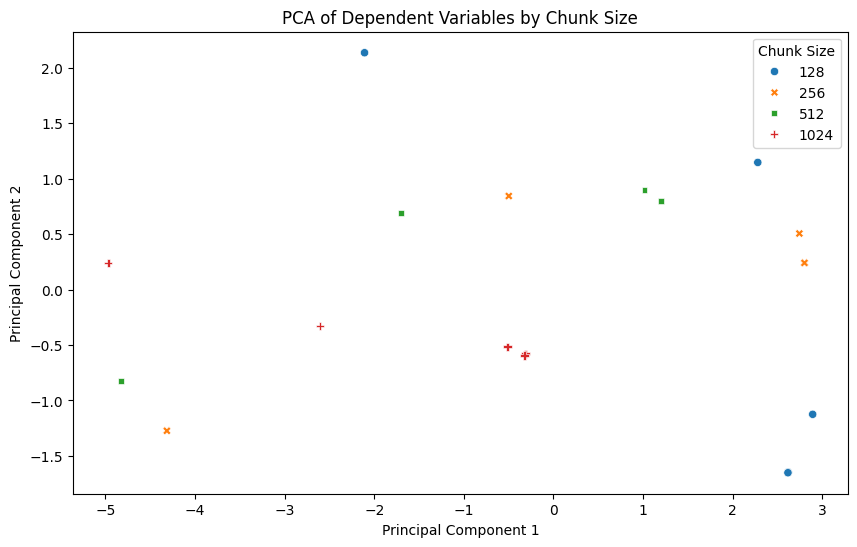

In [13]:
# PCA + MANOVA 
scores_df["group"] = scores_df["chunk_size"].astype(str)
df_clean = scores_df.dropna(subset=dv_columns + ["group"])

# Standardize the dependent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[dv_columns])

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add principal components to the dataframe
df_clean["PC1"] = X_pca[:, 0]
df_clean["PC2"] = X_pca[:, 1]

# Run MANOVA on the first two principal components
from statsmodels.multivariate.manova import MANOVA
maov_pca = MANOVA.from_formula("PC1 + PC2 ~ group", data=df_clean)
manova_pca_results = maov_pca.mv_test()
print("MANOVA results on PCA components:\n", manova_pca_results)
# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x="PC1", y="PC2", hue="group", style="group")
plt.title("PCA of Dependent Variables by Chunk Size")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Chunk Size")
plt.show()

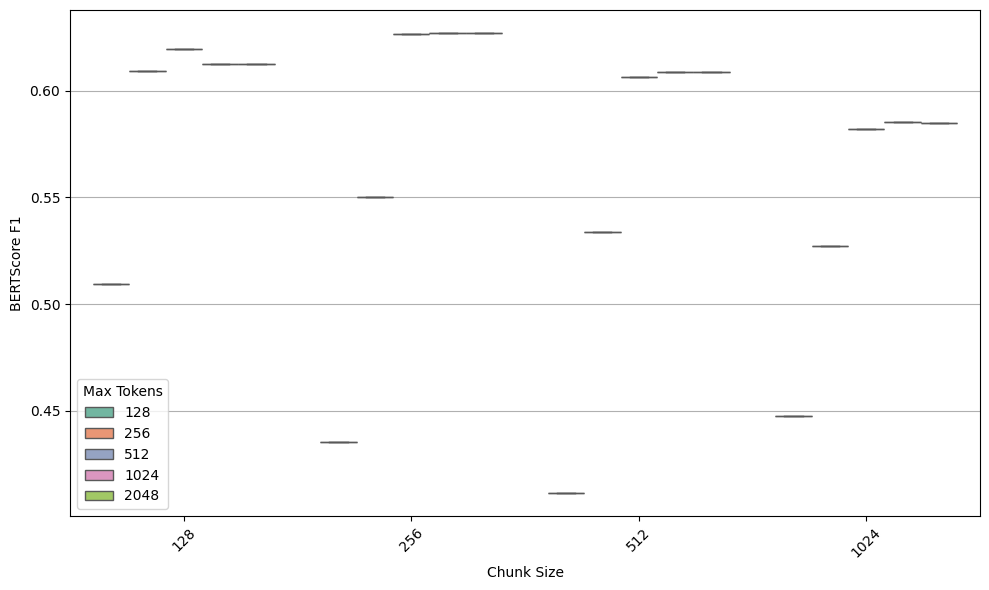

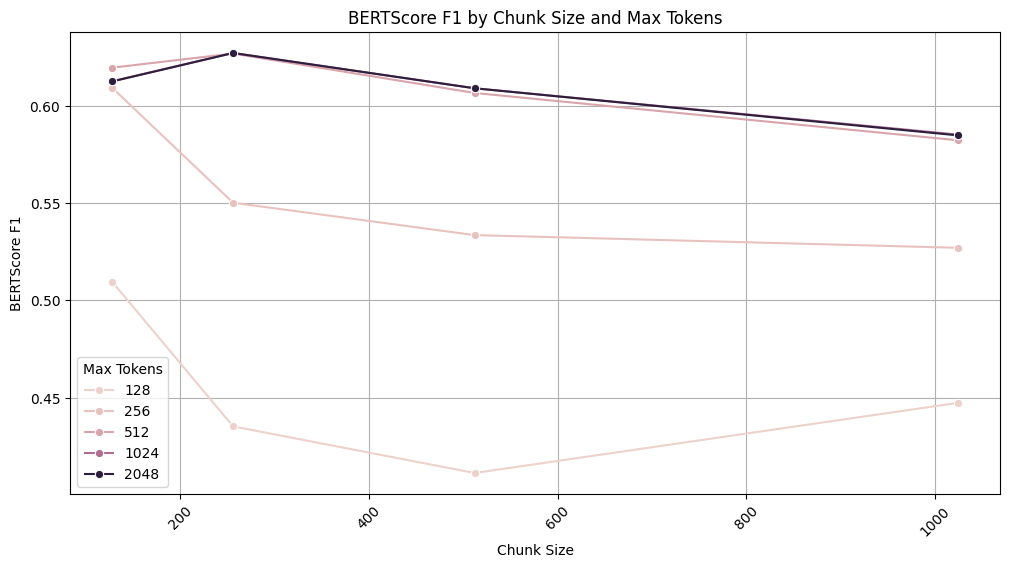

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='chunk_size', y='bert_score_F1', hue='max_tokens', data=scores_df, palette="Set2")
plt.xlabel("Chunk Size")
plt.ylabel("BERTScore F1")
plt.xticks(rotation=45)
plt.legend(title="Max Tokens")
plt.grid(axis='y')
plt.tight_layout()
plt.figure(figsize=(12, 6))
sns.lineplot(data=scores_df, x='chunk_size', y='bert_score_F1', hue='max_tokens', marker='o')
plt.xlabel("Chunk Size")
plt.ylabel("BERTScore F1")
plt.title("BERTScore F1 by Chunk Size and Max Tokens")
plt.xticks(rotation=45)
plt.legend(title="Max Tokens")
plt.grid()

In [15]:
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

pairwise_results = []
scores_df["group"] = scores_df["chunk_size"].astype(str)

# Looping through the combinations of groups
for grp1, grp2 in combinations(scores_df["group"].unique(), 2):
    subset = scores_df[scores_df["group"].isin([grp1, grp2])].copy()
    subset = subset.reset_index(drop=True)
    
    # Distance matrix
    X_pair = subset[dv_columns].values
    distance_array = squareform(pdist(X_pair, metric='euclidean'))
    ids = [str(i) for i in subset.index]
    distance_matrix = DistanceMatrix(distance_array, ids=ids)
    
    # DataFrame with group labels
    grouping_df = pd.DataFrame({'group': subset["group"].values}, index=ids)
    
    # PERMANOVA 
    result = permanova(distance_matrix, grouping=grouping_df, column='group', permutations=999)
    
    pairwise_results.append({
        "Group 1": grp1,
        "Group 2": grp2,
        "Pseudo-F": result["test statistic"],
        "p-value": result["p-value"]
    })

pairwise_df = pd.DataFrame(pairwise_results)
print(pairwise_df)


  Group 1 Group 2  Pseudo-F  p-value
0     128     256  0.245326    0.718
1     128     512  2.038426    0.192
2     128    1024  7.586664    0.042
3     256     512  0.556008    0.420
4     256    1024  2.834792    0.099
5     512    1024  1.020972    0.309


In [16]:
# Compute group means
group_means = scores_df.groupby('chunk_size')[dv_columns].mean().mean(axis=1).sort_index()
print("Group Means:")
print(group_means)

differences = []
# Calculate differences between each pair of groups
for (grp1, grp2) in combinations(group_means.index, 2):
    diff = group_means[grp2] - group_means[grp1]
    differences.append({
        "Group 1": grp1,
        "Group 2": grp2,
        "Mean Difference": diff
    })

differences_df = pd.DataFrame(differences)
print("Mean Differences between Groups:")
print(differences_df)


Group Means:
chunk_size
128     0.454682
256     0.428760
512     0.387702
1024    0.343928
dtype: float64
Mean Differences between Groups:
   Group 1  Group 2  Mean Difference
0      128      256        -0.025922
1      128      512        -0.066980
2      128     1024        -0.110754
3      256      512        -0.041058
4      256     1024        -0.084832
5      512     1024        -0.043773


In [17]:
# Step 1: Compute group means per DV
group_means = scores_df.groupby('chunk_size')[dv_columns].mean().sort_index()
print("Group Means:")
print(group_means)

# Step 2: Compute pairwise mean differences for each DV
differences = []
chunk_sizes = group_means.index.tolist()

for dv in dv_columns:
    for grp1, grp2 in combinations(chunk_sizes, 2):
        diff = group_means.loc[grp2, dv] - group_means.loc[grp1, dv]
        differences.append({
            "Dependent Variable": dv,
            "Group 1": grp1,
            "Group 2": grp2,
            "Mean Difference": diff
        })

# Step 3: Convert to DataFrame
differences_df = pd.DataFrame(differences)
print("Mean Differences between Groups for Each DV:")
print(differences_df)

Group Means:
              rouge1    rouge2    rougeL  rougeLsum  bert_score_P  \
chunk_size                                                          
128         0.368548  0.203984  0.251284   0.327214      0.669684   
256         0.337557  0.172066  0.209683   0.306672      0.684770   
512         0.250187  0.138413  0.162073   0.234033      0.702987   
1024        0.154966  0.089416  0.103597   0.146852      0.684956   

            bert_score_R  bert_score_F1  sts_score  
chunk_size                                          
128             0.550321       0.592712   0.673708  
256             0.506237       0.573339   0.639754  
512             0.467796       0.553916   0.592208  
1024            0.462919       0.545359   0.563361  
Mean Differences between Groups for Each DV:
   Dependent Variable  Group 1  Group 2  Mean Difference
0              rouge1      128      256        -0.030991
1              rouge1      128      512        -0.118361
2              rouge1      128     102

In [18]:
from scipy.stats import ttest_ind
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Pairwise t-tests for each dependent variable
results = []
for dv in dv_columns:
    for grp1, grp2 in combinations(scores_df["chunk_size"].unique(), 2):
        vals1 = scores_df[scores_df["chunk_size"] == grp1][dv]
        vals2 = scores_df[scores_df["chunk_size"] == grp2][dv]
        t_stat, p_val = ttest_ind(vals1, vals2, equal_var=False)
        results.append({
            "Outcome": dv,
            "Group 1": grp1,
            "Group 2": grp2,
            "t-statistic": t_stat,
            "raw p-value": p_val
        })

ttest_df = pd.DataFrame(results)

# Applying the FDR (Benjamini-Hochberg) correction
reject, fdr_pvals, sidak_thresh, bonf_thresh = multipletests(ttest_df["raw p-value"], method='fdr_bh')
ttest_df["FDR (BH) p-value"] = fdr_pvals
ttest_df["Significant (FDR < 0.05)"] = reject

# results
print(ttest_df.head())
ttest_df.to_csv("pairwise_ttests_fdr_microsoft_phi-4.csv", index=False)


  Outcome  Group 1  Group 2  t-statistic  raw p-value  FDR (BH) p-value  \
0  rouge1      128      256     0.334019     0.748857          0.816935   
1  rouge1      128      512     1.494450     0.176381          0.535510   
2  rouge1      128     1024     3.370797     0.009983          0.139439   
3  rouge1      256      512     0.857462     0.417359          0.711349   
4  rouge1      256     1024     2.025747     0.088705          0.484375   

   Significant (FDR < 0.05)  
0                     False  
1                     False  
2                     False  
3                     False  
4                     False  
